In [305]:
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.metrics import pairwise
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [317]:
data_path = "../data/neurips-2023-data/de_per_donor.h5ad"

In [318]:
adata = ad.read_h5ad(data_path)

In [319]:
threshold = 0.05

In [320]:
# create another layer with adj.P.Value thresholded
adata.layers['sign_log10_pval_thresholded'] = np.ones_like(adata.layers['sign_log10_pval'])
below_threshold_indices = adata.layers['adj.P.Value'] < threshold

adata.layers['sign_log10_pval_thresholded'][below_threshold_indices] = adata.layers['sign_log10_pval'][below_threshold_indices]

In [321]:
# create another layer with adj.P.Value thresholded
adata.layers['logfc_thresholded'] = np.ones_like(adata.layers['logFC'])
below_threshold_indices = adata.layers['adj.P.Value'] < threshold

adata.layers['logfc_thresholded'][below_threshold_indices] = adata.layers['logFC'][below_threshold_indices]

In [322]:
for w1, w2 in [(0.1, 0.9)]:
    weighted_sum = (w1 * np.abs(adata.layers['logFC'])) + (w2 * adata.layers['sign_log10_pval'])
    adata.layers[f'weighted_sum_{w1}_{w2}'] = weighted_sum

In [323]:
ranks = {
    'signature': [],
    'cell_type': [],
    'donor_id_1': [],
    'donor_id_2': [],
    'sm_name': [],
    'rank': [],
}

# Iterate over each layer (signature) to calculate cosine similarities
for signature in adata.layers.keys():
    print(f"Processing signature: {signature}")
    for cell_type in adata.obs['cell_type'].unique():
        # Filter data by sm_cell_type
        cell_type_adata = adata[adata.obs['cell_type'] == cell_type]
        sm_names = cell_type_adata.obs['sm_name'].unique()

        # Get unique donors within this sm_cell_type
        donors = cell_type_adata.obs['donor_id'].unique()

        # Iterate over all combinations of two different donors
        for donor_id_1, donor_id_2 in itertools.combinations(donors, 2):
            # Filter data for each donor
            donor_data_1 = cell_type_adata[cell_type_adata.obs['donor_id'] == donor_id_1]
            donor_data_2 = cell_type_adata[cell_type_adata.obs['donor_id'] == donor_id_2]
            
            for sm_name in donor_data_1.obs['sm_name'].unique():
                if sm_name not in donor_data_2.obs['sm_name'].unique():
                    continue
                # get index of sm_name in donor_data_2
                idx = np.where(donor_data_2.obs['sm_name'] == sm_name)[0][0]
                cosine_similarity = pairwise.cosine_similarity(
                    donor_data_1[donor_data_1.obs['sm_name'] == sm_name].layers[signature],
                    donor_data_2.layers[signature]
                )
                rank = np.where(np.argsort(-cosine_similarity) == idx)[1][0]
                ranks['signature'].append(signature)
                ranks['cell_type'].append(cell_type)
                ranks['donor_id_1'].append(donor_id_1)
                ranks['donor_id_2'].append(donor_id_2)
                ranks['sm_name'].append(sm_name)
                ranks['rank'].append(rank)

# Convert ranks to DataFrame for easier manipulation and output
ranks_df = pd.DataFrame(ranks)

Processing signature: P.Value
Processing signature: adj.P.Value
Processing signature: is_de
Processing signature: is_de_adj
Processing signature: logFC
Processing signature: sign_log10_nonadj_pval
Processing signature: sign_log10_pval
Processing signature: sign_log10_pval_thresholded
Processing signature: logfc_thresholded
Processing signature: weighted_sum_0.1_0.9


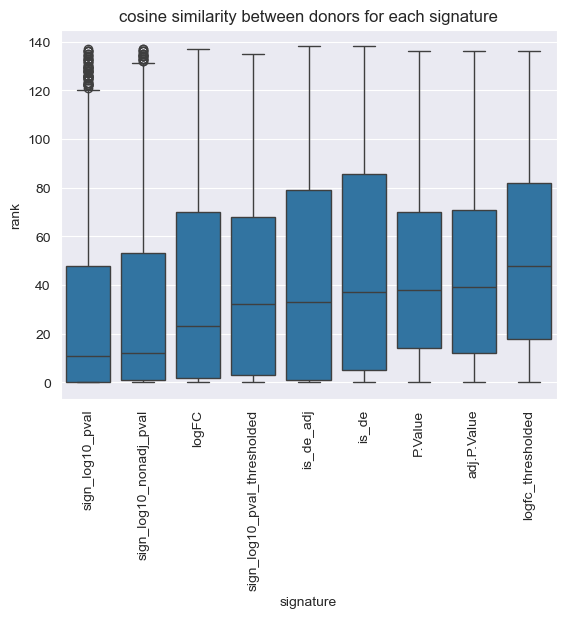

In [333]:
ranks_df_subset = ranks_df[~ranks_df.signature.isin(["weighted_sum_0.1_0.9"])]
ordered_signatures = ranks_df_subset.groupby('signature')['rank'].median().sort_values().index
sns.boxplot(data=ranks_df_subset, x='signature', y='rank', order=ordered_signatures)
plt.xticks(rotation=90)
plt.title('cosine similarity between donors for each signature')
plt.show()

In [315]:
# we see that signature 'sign_log10_pval' has the lowest rank, closely followed by non-adjusted sign_log10_pval and logFC.
# we skip the weighted_sum_0.1_0.9 which performs even a bit better, since we believe it requires further validation to be shown to be more than by chance
# We analyze these three signatures further

In [334]:
ranks_df_subset = ranks_df[ranks_df['signature'].isin(['sign_log10_pval', 'logFC', 'sign_log10_nonadj_pval'])]

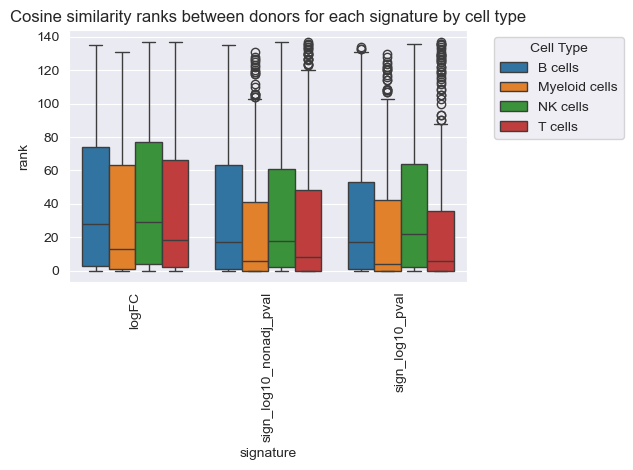

In [336]:
# same but per cell type, donor and sm_name
sns.boxplot(data=ranks_df_subset, x='signature', y='rank', hue='cell_type')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.title('Cosine similarity ranks between donors for each signature by cell type')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside of the plot
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

In [338]:
# we note that the representations appear to capture T cells and Myeloid cells best. B cells and NK cells are less consistent
# we focus on sign_log10_pval

In [400]:
ranks_df_subset = ranks_df[ranks_df['signature'].isin(['sign_log10_pval'])].copy()

In [348]:
ordered_signatures = ranks_df_subset.groupby('sm_name')['rank'].median().sort_values().index

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


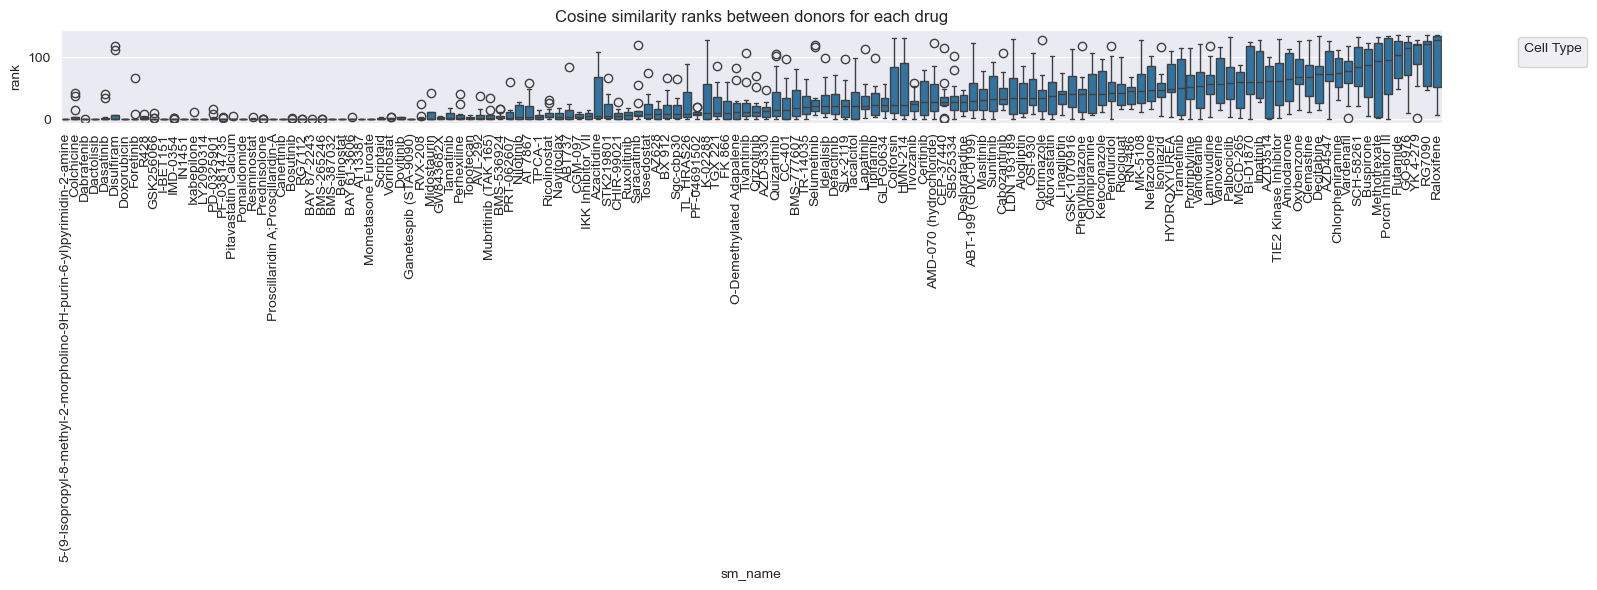

In [359]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=ranks_df_subset, x='sm_name', y='rank', order=ordered_signatures)
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.title('Cosine similarity ranks between donors for each drug')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside of the plot
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

In [448]:
adata.layers

Layers with keys: P.Value, adj.P.Value, is_de, is_de_adj, logFC, sign_log10_nonadj_pval, sign_log10_pval, sign_log10_pval_thresholded, logfc_thresholded, weighted_sum_0.1_0.9

In [454]:
adata_df = pd.DataFrame(adata.layers['adj.P.Value'], columns=adata.var_names)
adata_df['sm_name'] = adata.obs['sm_name'].values  # Add 'sm_name' from .obs to the DataFrame

# Step 2: Group by 'sm_name' and sum the 'sign_log10_pval'
grouped_sum = adata_df.groupby('sm_name').mean()

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_67729/2862755947.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = adata_df.groupby('sm_name').mean()


In [455]:
sum_sign_log10_pval = grouped_sum.mean(axis=1)
sm_name_to_sum_pval = sum_sign_log10_pval.to_dict()

In [456]:
ranks_df_subset["sum_pval"] = ranks_df_subset["sm_name"].map(lambda x: sm_name_to_sum_pval[x])

In [457]:
ranks_df_subset["median_rank"] = ranks_df_subset["sm_name"].map(ranks_df_subset.groupby('sm_name')['rank'].median().to_dict())

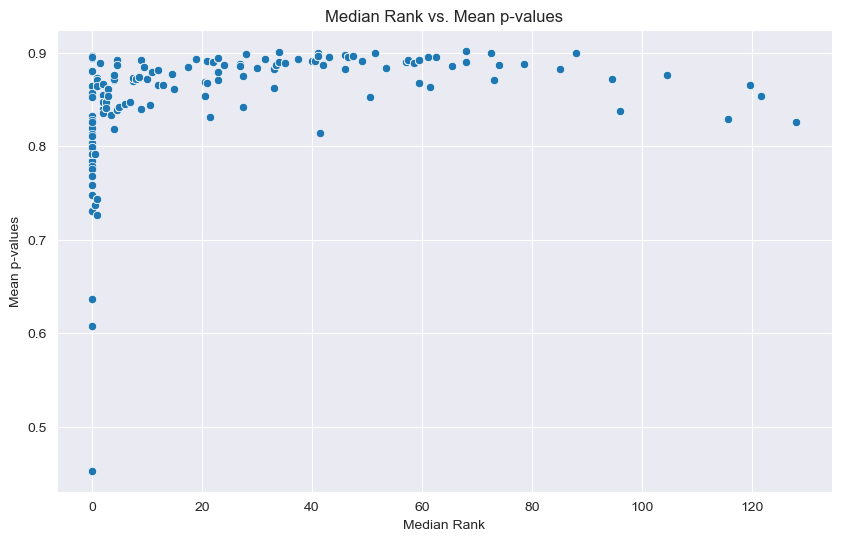

In [460]:
df_sorted = ranks_df_subset.sort_values('median_rank')

# Step 2: Create the plot using seaborn
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
ax = sns.scatterplot(data=df_sorted, x='median_rank', y='sum_pval')

# Optional: Customize the plot
plt.title('Median Rank vs. Mean p-values')
plt.xlabel('Median Rank')
plt.ylabel('Mean p-values')
# ax.set_xscale('log')
# ax.set_yscale('log')

# Show the plot
plt.show()

In [459]:
# molecules with low p-values and poor retrieval
ranks_df_subset[(ranks_df_subset['median_rank'] > 80) & (ranks_df_subset['sum_pval'] > 1000)].sm_name.unique()

array([], dtype=object)

In [426]:
# the only molecule that downregulates many genes
ranks_df_subset[ranks_df_subset['sum_pval'] < -1].sm_name.unique()

array(['Belinostat'], dtype=object)

In [461]:
# group molecules by signature

In [462]:
de_train_path = "../data/neurips-2023-data/de_train.h5ad"
de_test_path = "../data/neurips-2023-data/de_test.h5ad"

In [463]:
adata_train = ad.read_h5ad(de_train_path)
adata_test = ad.read_h5ad(de_test_path)

In [465]:
adata_test.X = adata_test.layers["sign_log10_pval"]

In [466]:
import scanpy as sc

In [472]:
adata_train.X = adata_train.layers["sign_log10_pval"]

In [473]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)

         Falling back to preprocessing with `sc.pp.pca` and default params.


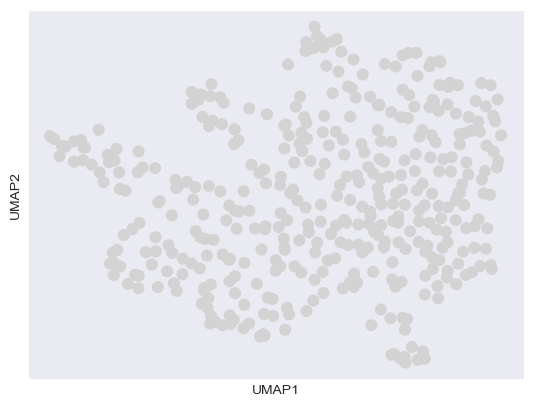

In [474]:
sc.pl.umap(adata_train)